**Task IX: Kolmogorov-Arnold Network**

Implement a classical Kolmogorov-Arnold Network using basis-splines or some other KAN architecture and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical KAN architecture to a quantum KAN and sketch out the architecture in detail.


Using cuda
Training KAN...
Epoch 1/5 (KAN)
[100] loss: 3025.934
[200] loss: 2475.516
[300] loss: 2007.092
[400] loss: 1601.272
[500] loss: 1204.235
[600] loss: 851.598
[700] loss: 562.750
[800] loss: 345.677
[900] loss: 168.108
Epoch 2/5 (KAN)
[100] loss: 40.003
[200] loss: 4.477
[300] loss: 2.593
[400] loss: 2.765
[500] loss: 2.609
[600] loss: 2.690
[700] loss: 2.621
[800] loss: 2.698
[900] loss: 2.595
Epoch 3/5 (KAN)
[100] loss: 2.650
[200] loss: 2.668
[300] loss: 2.695
[400] loss: 2.677
[500] loss: 2.686
[600] loss: 2.631
[700] loss: 2.644
[800] loss: 2.716
[900] loss: 2.715
Epoch 4/5 (KAN)
[100] loss: 2.613
[200] loss: 2.722
[300] loss: 2.592
[400] loss: 2.718
[500] loss: 2.673
[600] loss: 2.624
[700] loss: 2.656
[800] loss: 2.591
[900] loss: 2.582
Epoch 5/5 (KAN)
[100] loss: 2.647
[200] loss: 2.666
[300] loss: 2.723
[400] loss: 2.567
[500] loss: 2.583
[600] loss: 2.613
[700] loss: 2.655
[800] loss: 2.598
[900] loss: 2.650
KAN Training time: 247.33 seconds
Accuracy on test set: 8.6

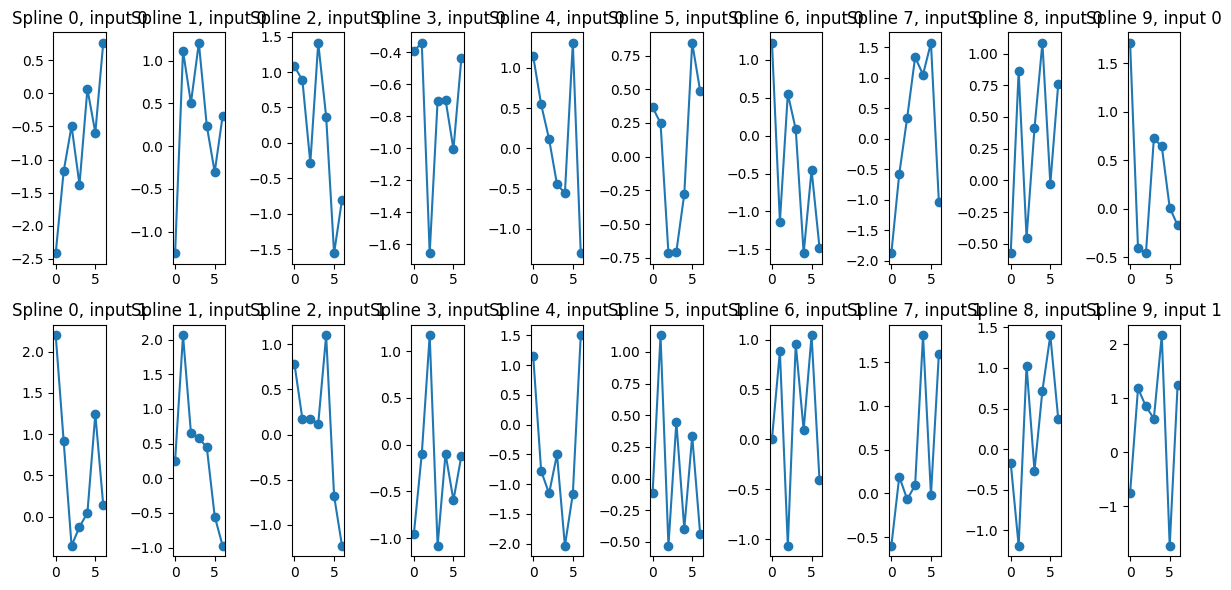

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
import time

class BSplineLayer(nn.Module):
    def __init__(self, num_control_points, input_dim=2, device="cpu"):
        super(BSplineLayer, self).__init__()
        self.num_control_points = num_control_points
        self.input_dim = input_dim
        self.device = device
        self.control_points = nn.Parameter(torch.randn(input_dim, num_control_points))
        self.knots = torch.linspace(0, 1, num_control_points + 4)


    def forward(self, x):
        batch_size = x.shape[0]
        outputs = torch.zeros(batch_size, device=self.device)

        for i in range(self.input_dim):
            knots_cpu = self.knots.cpu()
            spline = BSpline(
                t=knots_cpu.numpy(),
                c=self.control_points[i].cpu().detach().numpy(),
                k=3
            )
            outputs += torch.tensor(spline(x[:, i].cpu().detach().numpy()), device=self.device, dtype=torch.float32)

        return outputs

class KAN(nn.Module):
    def __init__(self, num_pairs, num_control_points, device="cpu"):
        super(KAN, self).__init__()
        self.device = device
        self.num_pairs = num_pairs
        self.spline_layers = nn.ModuleList([
            BSplineLayer(num_control_points, device=self.device) for _ in range(num_pairs)
        ])
        self.fc = nn.Linear(1, 10).to(self.device)


    def forward(self, x):
        batch_size = x.shape[0]
        summed_outputs = torch.zeros(batch_size, device=self.device, dtype=torch.float32)

        for i in range(self.num_pairs):
            summed_outputs += self.spline_layers[i](x[:, i, :])

        summed_outputs = summed_outputs.unsqueeze(1)
        out = self.fc(summed_outputs)
        return out

class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def load_data(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Resize((7, 7), antialias=True)
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def create_pairs(x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    pairs = []
    for i in range(x.shape[1]):
        pairs.append(torch.stack([x[:, i], x[:, (i + 1) % x.shape[1]]], dim=1))

    return torch.stack(pairs, dim=1)

def train(model, train_loader, optimizer, criterion, device, num_pairs=None):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        if isinstance(model, KAN):
          paired_images = create_pairs(images)
          outputs = model(paired_images)
        else:
          outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def evaluate(model, test_loader, device, num_pairs=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            if isinstance(model, KAN):
              paired_images = create_pairs(images)
              outputs = model(paired_images)
            else:
              outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')
    return accuracy

if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device}")

    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5
    num_control_points = 7
    num_pairs = 49
    input_size = 49
    hidden_size = 128
    num_classes = 10

    train_loader, test_loader = load_data(batch_size)

    print("Training KAN...")
    kan_model = KAN(num_pairs, num_control_points, device=device).to(device)
    criterion = nn.CrossEntropyLoss()
    kan_optimizer = optim.Adam(kan_model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} (KAN)")
        train(kan_model, train_loader, kan_optimizer, criterion, device, num_pairs)
    end_time = time.time()
    kan_training_time = end_time - start_time
    print(f"KAN Training time: {kan_training_time:.2f} seconds")

    kan_test_accuracy = evaluate(kan_model, test_loader, device, num_pairs)

    print("\nTraining FCNN...")
    fcnn_model = FCNN(input_size, hidden_size, num_classes).to(device)
    fcnn_optimizer = optim.Adam(fcnn_model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} (FCNN)")
        train(fcnn_model, train_loader, fcnn_optimizer, criterion, device)
    end_time = time.time()
    fcnn_training_time = end_time - start_time
    print(f"FCNN Training time: {fcnn_training_time:.2f} seconds")

    fcnn_test_accuracy = evaluate(fcnn_model, test_loader, device)


    print("\n--- Comparison ---")
    print(f"KAN Test Accuracy: {kan_test_accuracy:.2f}%")
    print(f"FCNN Test Accuracy: {fcnn_test_accuracy:.2f}%")
    print(f"KAN Training Time: {kan_training_time:.2f} seconds")
    print(f"FCNN Training Time: {fcnn_training_time:.2f} seconds")

    plt.figure(figsize=(12, 6))
    for i in range(min(num_pairs, 10)):
      for j in range(2):
        plt.subplot(2, 10, i + 1 + j*10)
        plt.plot(kan_model.spline_layers[i].control_points[j].cpu().detach().numpy(), 'o-', label=f'Spline {i}')
        plt.title(f'Spline {i}, input {j}')
    plt.tight_layout()
    plt.show()



# Quantum KAN Discussion and Architecture Sketch

## Quantum KAN (QKAN) Extension

Extending the classical KAN to a Quantum KAN (QKAN) involves replacing the classical B-spline transformations with quantum circuits. This allows us to leverage the potential advantages of quantum computation, such as superposition and entanglement, to potentially represent and learn more complex functions with fewer parameters.

### 1. Quantum Basis Function Approximation

- **Classical KAN:** Uses B-splines (or other basis functions) to approximate univariate functions. These are controlled by classical parameters (control points).
- **QKAN:** We can represent the basis function approximation using quantum states. Instead of classical control points, we use the parameters of a quantum circuit to manipulate the quantum state. The measurement outcomes of the quantum state (after applying the circuit) will correspond to the values of the basis function.

### 2. Replacing B-Splines with Quantum Circuits

- **Variational Quantum Circuits (VQCs):** VQCs are a natural choice. A VQC consists of parameterized quantum gates (rotations, entangling gates). The parameters of these gates become the "control points" of our quantum basis function. We can train these parameters using a classical optimizer, just like we train the control points of B-splines.
- **Quantum Fourier Transform (QFT):** The QFT can be used to create a quantum representation of a function in the Fourier basis. This offers an alternative to VQCs, especially if we expect the target function to have a sparse representation in the frequency domain. We would need to learn the coefficients of the Fourier series, which can be done by parameterizing a quantum circuit that prepares the corresponding state.

### 3. Architecture Sketch

- **Input Encoding:** The classical input (e.g., pixel values) needs to be encoded into a quantum state. Several encoding methods exist:
  - **Amplitude Encoding:** Encode the input values as amplitudes of a quantum state.
  - **Angle Encoding:** Encode the input values as angles of rotation gates.
  - **Basis Encoding:** Represent the input in a computational basis state.
- **Quantum Circuit Layers:** Similar to the classical KAN, we would have multiple layers of quantum circuits. Each "layer" would correspond to a univariate function in the KAN decomposition.
  - Each layer would consist of a VQC or a QFT-based circuit, parameterized by trainable parameters (analogous to control points).
  - The choice of gates and the circuit structure (ansatz) is crucial and depends on the problem.
- **Measurement:** After applying the quantum circuits, we need to measure the quantum state. We can measure in the computational basis or use other measurement schemes. The measurement outcomes will give us the values of the quantum basis functions.
- **Classical Post-Processing:** The measurement results (which are classical) are then combined (e.g., summed) and passed to a classical output layer (like the `fc` layer in the classical KAN) to produce the final prediction.
- **Training:** The parameters of the quantum circuits and the classical output layer are trained using a hybrid quantum-classical optimization loop. We compute the loss function (e.g., cross-entropy) on a classical computer and use a classical optimizer (like Adam) to update the parameters. The gradients with respect to the quantum circuit parameters can be computed using techniques like the parameter-shift rule.

### 4. Potential Advantages

- **Expressiveness:** Quantum circuits can potentially represent a wider class of functions than classical B-splines, potentially leading to better accuracy with fewer parameters.
- **Quantum Speedup:** For certain types of functions, quantum circuits might offer a computational advantage over classical methods. However, this is highly dependent on the specific problem and the chosen quantum algorithm.

### 5. Challenges

- **Hardware Limitations:** Current quantum computers are noisy and have limited qubits. This restricts the size and complexity of the quantum circuits we can use.
- **Training Complexity:** Training hybrid quantum-classical models can be computationally expensive.
- **Encoding:** Choosing the right encoding scheme for classical data into quantum states is crucial and can significantly impact performance.

In summary, QKANs represent a promising avenue for combining the strengths of Kolmogorov-Arnold Networks and quantum computation. However, significant research is still needed to overcome the challenges and realize their full potential.